önceki ayların aylık yolcu sayısına göre sonraki ayları tahmin etmece

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [5]:
df = pd.read_csv('/international-airline-passengers.csv')
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns= ["Months", "Passengers"]
df.head()

,Months,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail()

,Months,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.shape

(145, 2)

In [9]:
df.dtypes

,0
Months,object
Passengers,float64


In [10]:
df.isna().sum()

,0
Months,0
Passengers,1


In [11]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [12]:
df=df[:144]
df.tail()

,Months,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [13]:
df["Months"]=pd.to_datetime(df["Months"])
df.dtypes

,0
Months,datetime64[ns]
Passengers,float64


In [14]:
print("max tarih:", df["Months"].max())
print("min tarih:", df["Months"].min())

max tarih: 1960-12-01 00:00:00
min tarih: 1949-01-01 00:00:00


In [15]:
df.index = df["Months"]
df.drop("Months", axis=1, inplace=True)
df.head()

,Passengers
Months,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [16]:
result_df = df.copy()

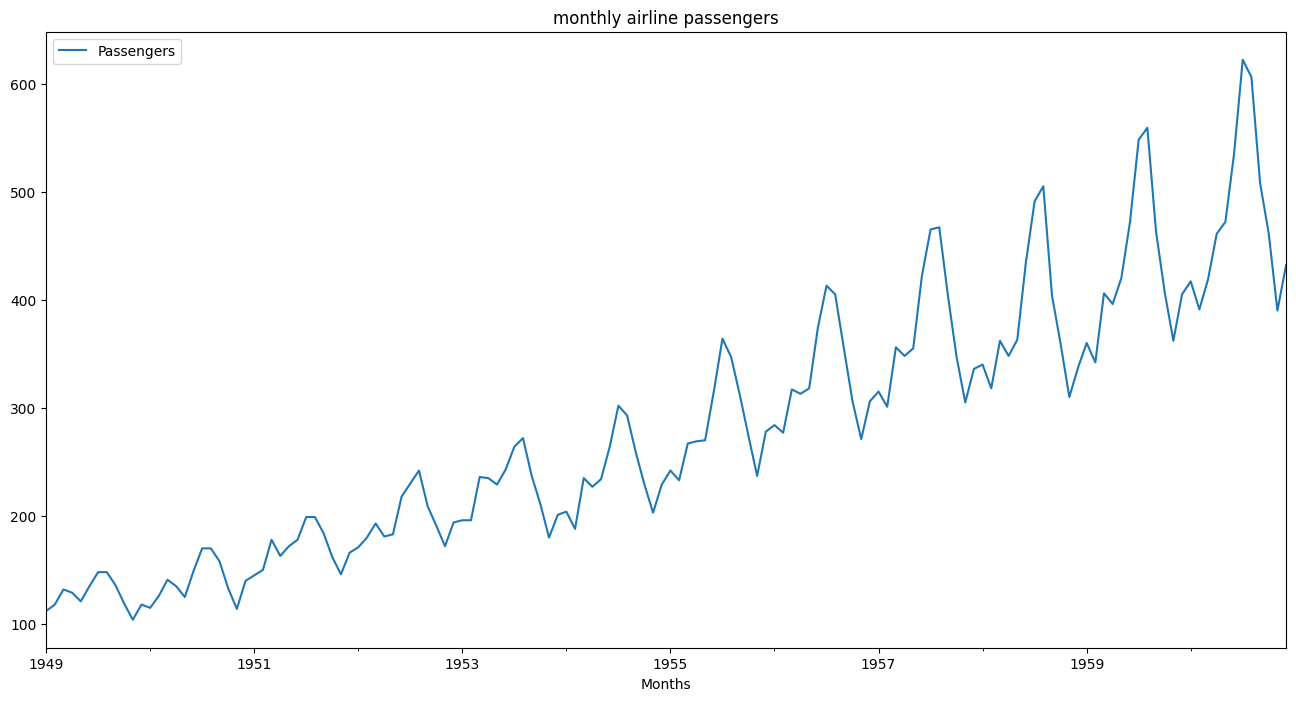

In [17]:
df.plot(figsize=(16,8), title="monthly airline passengers")
plt.show()

In [18]:
data = df["Passengers"].values
data[0:5]

array([112., 118., 132., 129., 121.])

In [19]:
type(data[0:5]) #modellemede kullanabilmek için dataframeden kurtulmamız lazımdı

numpy.ndarray

In [20]:
type(data[0]) #float32 oolmalı

numpy.float64

In [21]:
data = data.astype("float32")
type(data[0])

numpy.float32

In [22]:
data = data.reshape(-1,1)
data.shape

(144, 1)

In [23]:
#zaman serilerinde sklearn train test split kullanmak çok mantıklı olmaz
#çünkü rastegelelik oluşturur ve örüntü kaybolur

def split_data(dataframe, test_size):
  position= int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [24]:
train, test, position= split_data(data, 0.33)

In [25]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [26]:
#normalizasyon
#data leakage olmsaın diye test ve traini ayrı ayrı yapıyıoz
scaler_train= MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)
scaler_test= MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [27]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [28]:
#feature eklemesi yapıcaz
#t anı en çok t-1. andan etkilendiği için bunu ayrıca eklememiz lazım
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0]) #bir önceki
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [29]:
lookback=1
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(95, 1) (95,)
(47, 1) (47,)


In [31]:
#rnn veriyi 3 boyutlu bir şekilde ister
X_train = np.reshape(X_train, (X_train.shape[0],1,  X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,  X_test.shape[1]))
y_train =y_train.reshape(-1,1)
y_test =y_test.reshape(-1,1)

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(95, 1, 1) (95, 1)
(47, 1, 1) (47, 1)


In [33]:
model = Sequential()
model.add(SimpleRNN(units=50,activation="relu", input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss="mean_squared_error", optimizer="adam") #regresyon yani çıktı sayısal bir değer bu yyüzden mean squared

In [36]:
callbacks= [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
            ModelCheckpoint(filepath="best_model.keras", monitor="val_loss",
                            save_best_only=True, save_weights_only=False, verbose=1)]

In [37]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data= (X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/50
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 1: val_loss improved from inf to 0.03749, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0151 - val_loss: 0.0375
Epoch 2/50
68/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0437
Epoch 2: val_loss improved from 0.03749 to 0.02894, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393 - val_loss: 0.0289
Epoch 3/50
68/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312
Epoch 3: val_loss improved from 0.02894 to 0.02632, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - val_loss: 0.0263
Epoch 4/50
66/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 4: val_loss improved from 0.02632 to 0.02552, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.0255
Epoch 5/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 5: val_loss improved from 0.02552 to 0.02

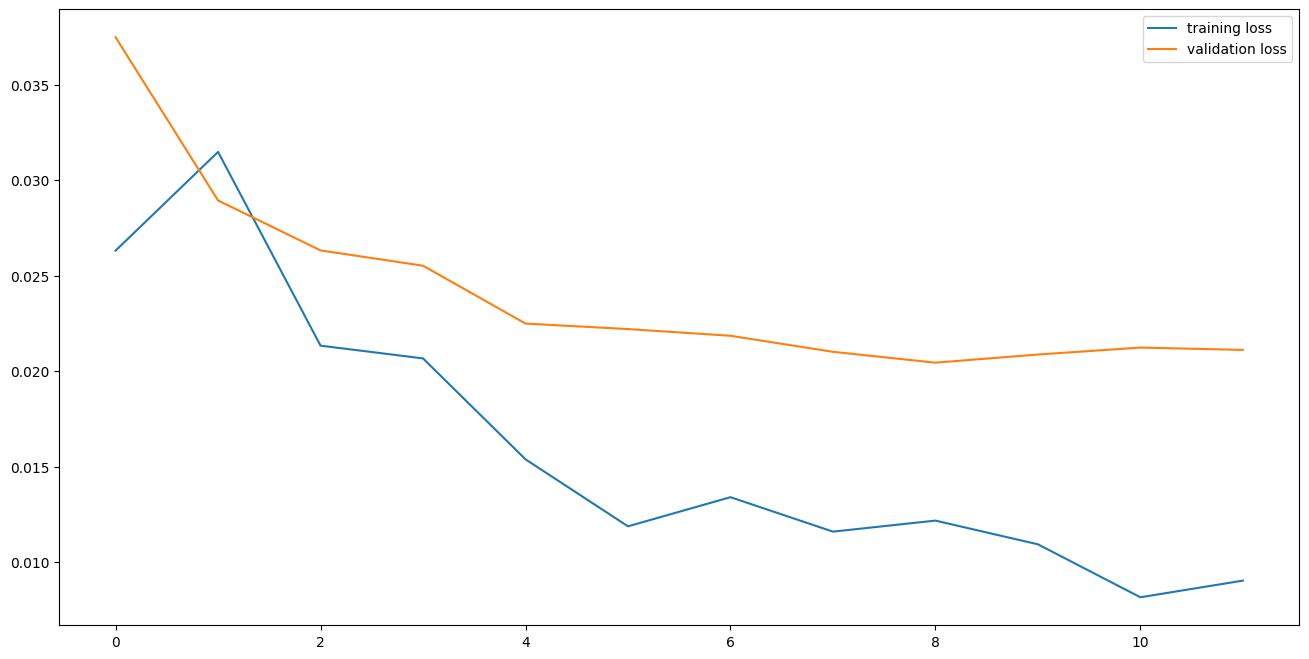

In [38]:
plt.figure(figsize=(16,8))
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

In [39]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("loss:", loss)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
loss: 0.021110551431775093


In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [41]:
#daha doğru bir hata değeri almak için
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [42]:
y_train= scaler_train.inverse_transform(y_train)
y_test= scaler_test.inverse_transform(y_test)

In [43]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [44]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [45]:
print("train rmse:", train_rmse)
print("test rmse:", test_rmse)

train rmse: 23.9757
test rmse: 46.639603


In [47]:
#verimizdeki 0. elemanın bir öncesi olmadığı için
#lookback=1 atamıştık o yüzden ondan başlatıyrouz
train_prediction_df = result_df[lookback:position]

In [48]:
train_prediction_df["predicted"] = train_predict

In [49]:
train_prediction_df.head()

,Passengers,predicted
Months,,
1949-02-01,118.0,134.212158
1949-03-01,132.0,137.829803
1949-04-01,129.0,147.966080
1949-05-01,121.0,145.267151
1949-06-01,135.0,139.657883


In [52]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["predicted"]=test_predict
test_prediction_df.head()

,Passengers,predicted
Months,,
1957-02-01,301.0,335.812286
1957-03-01,356.0,328.802521
1957-04-01,348.0,369.985535
1957-05-01,355.0,362.788452
1957-06-01,422.0,369.085907


Text(0.5, 1.0, 'monthly airline passengers')

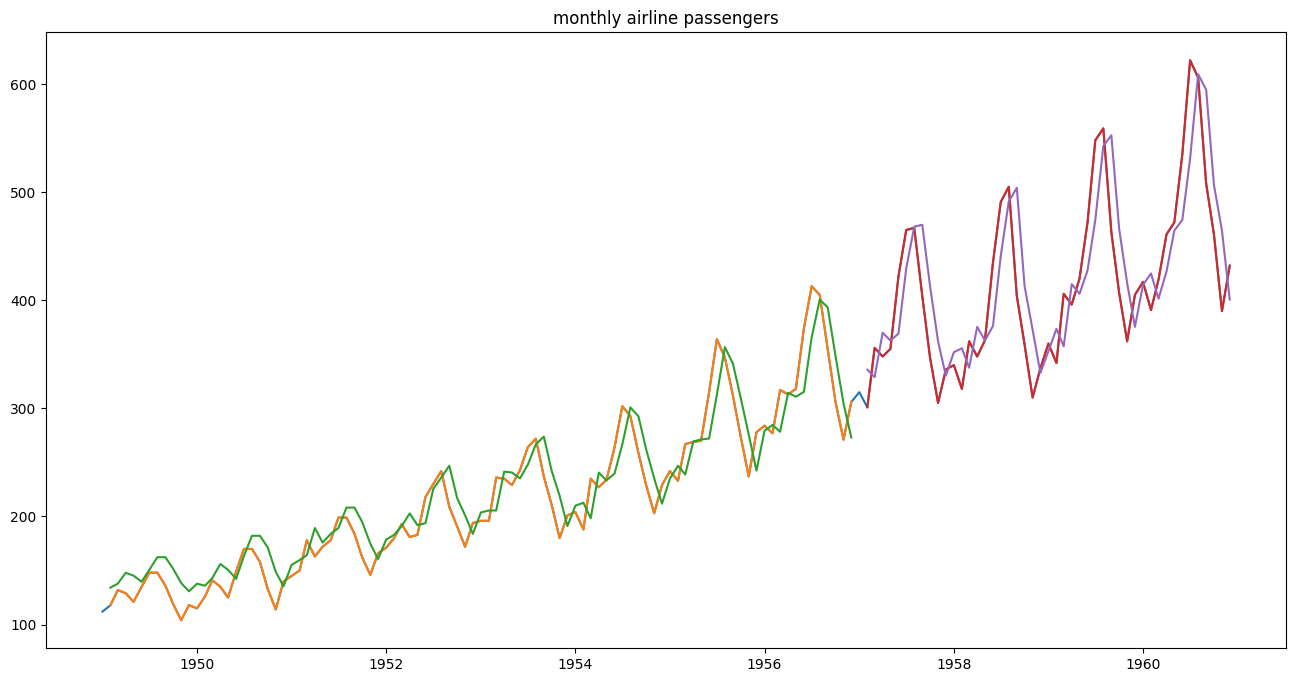

In [56]:
plt.figure(figsize=(16,8))
plt.plot(result_df, label="real number of passengers")
plt.plot(train_prediction_df, label="predicted number of passengers")
plt.plot(test_prediction_df, label="predicted number of passengers")
plt.title("monthly airline passengers")